Table of contents
* [Introduction](#Introduction)
* [Getting Data](#Getting-Data)
* [Data munging](#Data-munging)
* [Importing spatial data](#Importing-spatial-data)
* [Statisical analysis](#Statistical-analysis)

# Introduction

This noteboook provides an example of using real world data to produce a risk-based classification of potential damage from rainfall in the UK.

Steps:
- Scrape rainfall data and house price dataset
- Get a corresponding spatial dataset
- Use a Bayesian approach to fit the Extreme Value distribution to the rainfall dataset
- Use results of the statistical analysis in combination with average house prices to provide a risk-based categorisation of each spatial unit
- Visualise results on a choropleth map

# Getting Data

This notebook will make use of the Python library BeautifulSoup4 for web scraping. Historical met station data is available from the [Met Office](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data). 

In [1]:
from io import StringIO # for parsing text
import re
import time # to sleep between requests

from bs4 import BeautifulSoup
import pandas as pd
import requests # to handle html requests

In [2]:
# scrape historical weather data from met office
# https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data
base_url = 'https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data'
page = requests.get(base_url)
soup = BeautifulSoup(page.content)
station_links = soup.select("option")[1:] # skip first element (not a station)

In [3]:
# Create dictionary where keys are station names and values are a list of length
# 1 containing the link to station historical data. A list is used because, the
# station data itself will be added.
station_dict = {}
for each_tag in station_links:
    
    station_name = each_tag.text
    station_link = each_tag.attrs['value']

    station_dict.update({station_name: [station_link]})

In [4]:
# get station data, parse into pandas dataframe and retrieve station metadata
for key, val in station_dict.items():
    # send get request
    r = requests.get(val[0])
    # print(r.status_code) # uncomment for verbose output
    data = BeautifulSoup(r.content)
    string_buf = StringIO(data.text)
    metadata = StringIO(data.text).readlines()[:5]
    df_cols = ['Year','Month','tMax','tMin','Air Frost','Rainfall', 'Sun hours']
    df = pd.read_fwf(StringIO(data.text), skiprows=7, sep=' ',
                     na_values=['---', '--'], names=df_cols)
    val.extend([df, metadata])
    # print(f'{key} complete') # uncomment for verbose output
    time.sleep(.2) # pause between GET requests

# Data munging

In [5]:
relocated_list = [] # a list of stations that were relocated during the time 
                    # series. We'll use the most recent location.
for key, val in station_dict.items():
    try:
        lat, lon = [float(coord) for coord in re.findall(r'[-.\d]+', val[2][1].split(',')[1])]
        val.extend([lat, lon])
    except ValueError:
        # get lat and lon from relocated stations. Data appears on the following line
        lat, lon = [float(coord) for coord in re.findall(r'[-.\d]+', val[2][2].split(',')[1])]
        print(f'{key} was relocated during the timeseries.')
        val.extend([lat, lon])
        pass
    except IndexError:
        relocated_list.extend([key])

Braemar No 2 was relocated during the timeseries.
Southampton Mayflower Park was relocated during the timeseries.


Met station data is non-standard i.e. there are multiple different ways that 
missing measurements are represented ('---', '--'). These blocks of code extract
measurements into a standard format and add some metadata that will be needed
such as the coordinates of each Met station.

In [6]:
# parse the lat, lon by hand for these stations
# relocated_list = ['Lowestoft Monckton Avenue', 'Nairn Druim', 'Whitby']

station_dict['Lowestoft Monckton Avenue'][2]
lat, lon = 52.483, 1.727
station_dict['Lowestoft Monckton Avenue'].extend([lat, lon])

station_dict['Nairn Druim'][2]
lat, lon = 57.593, -3.821
station_dict['Nairn Druim'].extend([lat, lon])

station_dict['Whitby'][2]
lat, lon = 54.481, -0.624
station_dict['Whitby'].extend([lat, lon])

In [7]:
for key, val in station_dict.items():
    df = val[1]
    if df.loc[0, 'Sun hours'] == 'hours':
        station_dict[key][1] = df.iloc[1:].reset_index(drop=True)
        df = df.iloc[1:]
        print(f'Removed units header from {key}.')
    else:
        print(f'{key} okay.')

Aberporth okay.
Armagh okay.
Ballypatrick Forest okay.
Bradford okay.
Removed units header from Braemar No 2.
Camborne okay.
Cambridge Niab okay.
Cardiff Bute Park okay.
Chivenor okay.
Cwmystwyth okay.
Dunstaffnage okay.
Durham okay.
Eastbourne okay.
Eskdalemuir okay.
Heathrow okay.
Hurn okay.
Lerwick okay.
Leuchars okay.
Removed units header from Lowestoft Monckton Avenue.
Manston okay.
Removed units header from Nairn Druim.
Newton Rigg okay.
Oxford okay.
Paisley okay.
Ringway okay.
Ross-on-wye okay.
Shawbury okay.
Sheffield okay.
Removed units header from Southampton Mayflower Park.
Stornoway Airport okay.
Sutton Bonington okay.
Tiree okay.
Valley okay.
Waddington okay.
Removed units header from Whitby.
Wick Airport okay.
Yeovilton okay.


In [8]:
# Air Frost and Sun hours won't be used in this notebook
cols_to_drop = ['Air Frost', 'Sun hours']
for key, val in station_dict.items():
    station_dict[key][1] = station_dict[key][1].drop(columns=cols_to_drop)
    station_dict[key][1] = station_dict[key][1].replace({'\*': ''}, regex=True)

<>:5: SyntaxWarning: invalid escape sequence '\*'
<>:5: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_45043/292108890.py:5: SyntaxWarning: invalid escape sequence '\*'
  station_dict[key][1] = station_dict[key][1].replace({'\*': ''}, regex=True)


In [9]:
# These sites have strings as end of file markers in their last row.
station_dict['Cwmystwyth'][1] = station_dict['Cwmystwyth'][1].iloc[:-1] # last row is string
station_dict['Ringway'][1] = station_dict['Ringway'][1].iloc[:-1] # last row is string
station_dict['Southampton Mayflower Park'][1] = station_dict['Southampton Mayflower Park'][1].iloc[:-1] # last row is string

In [10]:
# Assign the correct data types to each column
for key, val in station_dict.items():
    station_dict[key][1] = station_dict[key][1].astype(
    {'Year': 'Int64',
    'Month': 'Int64',
    'tMax': 'float32',
    'tMin': 'float32',
    'Rainfall': 'float32'}
    )

Aberporth
Armagh
Ballypatrick Forest
Bradford
Braemar No 2
Camborne
Cambridge Niab
Cardiff Bute Park
Chivenor
Cwmystwyth
Dunstaffnage
Durham
Eastbourne
Eskdalemuir
Heathrow
Hurn
Lerwick
Leuchars
Lowestoft Monckton Avenue
Manston
Nairn Druim
Newton Rigg
Oxford
Paisley
Ringway
Ross-on-wye
Shawbury
Sheffield
Southampton Mayflower Park
Stornoway Airport
Sutton Bonington
Tiree
Valley
Waddington
Whitby
Wick Airport
Yeovilton


In [ ]:
# Uncomment to export DataFrames
'''
for each_site, each_df in station_dict.items():
    each_df[1].to_csv(f'{each_site}.csv', index=False)
'''

### Importing spatial data

In [2]:
import os 

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import MonthEnd

In [3]:
# Retrieve previously scraped Met station data
fnames = [f for f in os.listdir('data') if f.endswith('.csv')]
data_dir = 'data'
data_dict = {}
for each_fname in fnames:
    data_dict[each_fname.split('.')[0]] = pd.read_csv(f'{data_dir}/{each_fname}')

# sort sites alphabetically
data_dict = dict(sorted(data_dict.items()))

In [4]:
# Set DataFrame indicies to be DateTime objects
for each_site, each_df in data_dict.items():
    each_df['Date'] = pd.to_datetime(dict(year=each_df['Year'], month=each_df['Month'], day=1)) + MonthEnd(0)
    data_dict[each_site] = each_df.set_index('Date', drop=True)
    cols_to_drop = ['Year', 'Month']
    data_dict[each_site] = data_dict[each_site].drop(cols_to_drop, axis=1)

In [5]:
def drop_unused_cols(data_dict, cols_to_keep=['Rainfall']):
    """Iterate through each DataFrame in data_dict and only keep columns specified in
    cols_to_keep. NB this function modifies data_dict in place. Returns modified data_dict."""

    for each_station, each_df in data_dict.items():
        data_dict[each_station] = each_df.loc[:, cols_to_keep]

    return data_dict

# Remove unneeded variables from columns in each dataframe
drop_unused_cols(data_dict)

{'Aberporth':             Rainfall
 Date                
 1941-01-31      74.7
 1941-02-28      69.1
 1941-03-31      76.2
 1941-04-30      33.7
 1941-05-31      51.3
 ...              ...
 2025-01-31     115.0
 2025-02-28      59.2
 2025-03-31      16.8
 2025-04-30      84.8
 2025-05-31      15.8
 
 [1013 rows x 1 columns],
 'Armagh':             Rainfall
 Date                
 1853-01-31      57.3
 1853-02-28      32.3
 1853-03-31      65.5
 1853-04-30      46.2
 1853-05-31      13.2
 ...              ...
 2025-01-31      38.8
 2025-02-28      40.2
 2025-03-31      17.8
 2025-04-30      56.6
 2025-05-31      36.2
 
 [2069 rows x 1 columns],
 'Ballypatrick Forest':             Rainfall
 Date                
 1961-07-31       NaN
 1961-08-31       NaN
 1961-09-30       NaN
 1961-10-31       NaN
 1961-11-30       NaN
 ...              ...
 2025-01-31      30.0
 2025-02-28      63.0
 2025-03-31      32.0
 2025-04-30      85.0
 2025-05-31      66.0
 
 [767 rows x 1 columns],
 'Bradford': 

These blocks of code import supporting data. UK house price data isn't not spatially aware, so spatial information will be imported seperately and joined to the house price data. Administritive boundaries are in a geographic coordinate system. Met station data will be assosicated to areas based on distance, so these coordinates will be reprojected into a projected coordinate system.

In [6]:
# This .csv contains average house prices by administrative unit
house_price_df = pd.read_csv('Average-prices-2025-04.csv', index_col='Date')

# truncate house price data to 1 day and drop uneeded columns
house_price_df = house_price_df.loc['2025-04-01':'2025-04-01', ['Region_Name', 'Average_Price']]

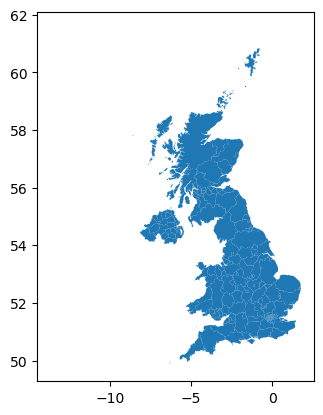

In [7]:
# Import spatial information on adminstrive boundaries in the UK as the house 
# price data is not spatial aware
admin_boundaries_gdf = gpd.read_file('GBR_adm.zip', layer='GBR_adm2')
admin_boundaries_gdf.plot();

In [8]:
house_price_gdf = admin_boundaries_gdf.merge(house_price_df, left_on='NAME_2', right_on='Region_Name', how='left')
house_price_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Create a GeoDataFrame of met station coordinates
station_coords_df = pd.read_csv('station_coords.csv')
station_coords_gdf = gpd.GeoDataFrame(station_coords_df,
                         geometry=gpd.points_from_xy(station_coords_df.Lon,
                                                     station_coords_df.Lat),
                                      crs=house_price_gdf.crs
                                     )

In [20]:
# remove continguous nan occurring at the start or end of valid data
def trim_nan_from_head_and_tail(df, print_if_still_nan='n'):
    """This function takes a pandas DataFrame and trim contingous nans which
    occur at the start or end of valid data. It returns the trimmed DataFrame.
    NB nans occurring between valid data are not removed. Pass kwarg 'y' to
    print number of remaining nan values."""

    start_of_data = df.first_valid_index()
    end_of_data = df.last_valid_index()
    df = df.loc[start_of_data:end_of_data]
    if print_if_still_nan == 'y':
        num_nans = df.isna().sum().to_string(index=False) 
        print(f'This dataset still contains {num_nans} nan values.')
        
    return df

def interpolate_nans(df):
    """This function uses linear interpolation to fill missing values in each
    dataset in data_dict. It takes a pandas DataFrame and returns the
    interpolated DataFrame."""

    interpolated_df = df.interpolate()
    return interpolated_df

for each_site, each_df in data_dict.items():
    data_dict[each_site] = trim_nan_from_head_and_tail(each_df)
    data_dict[each_site] = interpolate_nans(data_dict[each_site])    

# Statistical analysis

The generalized extreme value distribution will be used to distributions of parameters for rainfall data across the UK.

Approach:
- Use the annual maxima for each site as 'extreme' values
- Use PyMC to find the posterior distribution for each parameter
- Use the posterior distribution to estimate the rainfall intensity for a selection of return periods
- Incorporate average house prices to make a 'risk-factor'

References: Based on Jorn Mossel's [PyData 2023 talk](https://github.com/jjmossel/extremeweather/blob/main/PyData2023_JornMossel_Modeling%20Extreme%20Events%20with%20PyMC.pdf)

In [11]:
import arviz as az
import multiprocessing # To stop connection time out error on Fedora 41 when initiating MCMC sampler from pymc
import pymc as pm
import pymc_extras.distributions as pmx

In [12]:
# much slower to start but prevents 'connection reset error'
multiprocessing.set_start_method('spawn', force=True)

In [13]:
def get_annual_max(data_dict):
    """This function takes a dictionary of pandas DataFrames and resamples by
    year, returning the maxima. It return a dictionary containing the resampled
    DataFrames."""

    maxima_dict = data_dict.copy()
    for each_site, each_df in maxima_dict.items():
        maxima_dict[each_site] = each_df.resample('YE').max()

    return maxima_dict

maxima_dict = get_annual_max(data_dict)

In [14]:
def build_model(df):
    """Build generalized extreme value model."""

    mu_estimate = df.median().to_numpy()
    sigma_estimate = df.std().to_numpy()
    with pm.Model() as model:
        # priors
        mu = pm.Normal('mu', mu=mu_estimate, sigma=10) # location
        sigma = pm.HalfNormal('sigma', sigma=sigma_estimate) # scale
        xi = pm.TruncatedNormal('xi', mu=0, sigma=.002, lower=-0.5, upper=0.5) # shape
    
        # estimation
        gev = pmx.GenExtreme('Rainfall', mu=mu, sigma=sigma, xi=xi, observed=df.to_numpy())
        idata = pm.sample_prior_predictive(draws=50, random_seed=42)

    return model, idata, mu, sigma, xi


def run_inference(model, idata):
    """Samples from model"""
    with model:
        idata.extend(pm.sample(
            1000,
            cores=4,
            chains=4,
            tune=300
        ))
    return idata


def plot_prior_check(idata):
    """Plot samples from the priors"""

    fig, ax = plt.subplots(figsize=(10,7))
    az.plot_ppc(idata, group='prior', ax=ax)
    ax.set_xlim([0, 180])
    ax.set_ylim([0, .4])
    
    return


def get_posterior_predictive(model, idata):
    """Sample from the posterior predictive and add to model inference object."""
        
    with model:
        pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

    return model, idata


def plot_posterior(idata):
    """Plots posterior check."""
    
    az.plot_ppc(idata, num_pp_samples=100)

    return


def predict_return_period_and_intensity(model, idata, mu, sigma, xi):
    """Use the pp to predict return period and intensity for 100 years."""
    
    return_periods = np.logspace(1,2, num=idata.posterior_predictive.Rainfall.shape[2])
    
    with model:
        rp = pm.Data("rp", return_periods) # return period
        ri = pm.Deterministic("ri", mu - sigma/xi * (1 - (-np.log(1 - 1/rp)) ** (-xi))) # return intensity
        post_pred = pm.sample_posterior_predictive(idata, var_names=['ri'])

    return post_pred, rp, ri, return_periods

def plot_return_period(post_pred, return_periods):
    
    y_data = az.summary(post_pred.posterior_predictive, var_names='ri', hdi_prob=0.95)
    x = return_periods
    y = y_data['mean']
    y_lower_conf =y_data['hdi_2.5%']
    y_upper_conf =y_data['hdi_97.5%']
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.fill_between(x, y_lower_conf, y_upper_conf, alpha=.15)
    return y_data, x


def fit_gev(df):
    """Build model and run inference. This function returns a dictionary
    containing: the model, an inference object, the posterior predictive,
    the return periods used to generate the return intensity, the return
    intensity i.e. mm of rainfaill, the mean prediction, the lower HDI, the
    upper HDI and the full arviz.summary object."""

    model, idata, mu, sigma, xi = build_model(df)
    idata = run_inference(model, idata)
    model, idata = get_posterior_predictive(model, idata)
    post_pred, rp, ri, return_periods = predict_return_period_and_intensity(model, idata, mu, sigma, xi)
    y_data = az.summary(post_pred.posterior_predictive, var_names='ri', hdi_prob=0.95)
    results_dict = {'model': model, 'idata': idata, 'post_pred': post_pred,
                    'return periods': return_periods, 
                    'return intensity': y_data['mean'],
                    'Lower': y_data['hdi_2.5%'],
                    'Upper': y_data['hdi_97.5%'],
                    'az_summary': y_data
                   }
    return results_dict

In [22]:
# Fit the GEV distribution to each dataset and put results in a dict
results_dict = {}
for each_site, each_df in data_dict.items():
    print(f'Processing {each_site}')
    results_dict[each_site] = fit_gev(each_df)

Sampling: [Rainfall, mu, sigma, xi]


Processing Aberporth


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Armagh


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 44 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Ballypatrick Forest


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Bradford


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 53 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Braemar No 2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Camborne


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cambridge Niab


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cardiff Bute Park


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Chivenor


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Cwmystwyth


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Dunstaffnage


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Durham


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 43 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Eastbourne


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Eskdalemuir


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 40 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Heathrow


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Hurn


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Lerwick


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Leuchars


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Lowestoft Monckton Avenue


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Manston


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 38 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Nairn Druim


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Newton Rigg


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 40 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Oxford


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 41 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Paisley


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Ringway


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 36 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Ross-on-wye


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Shawbury


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Sheffield


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 44 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Southampton Mayflower Park


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 42 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Stornoway Airport


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Sutton Bonington


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 44 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Tiree


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Valley


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Waddington


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 40 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Whitby


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 37 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Wick Airport


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 40 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

Sampling: [Rainfall, mu, sigma, xi]


Processing Yeovilton


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 300 tune and 1_000 draw iterations (1_200 + 4_000 draws total) took 39 seconds.
Sampling: [Rainfall]


Output()

Sampling: []


Output()

In [ ]:
def create_metrics_df(results_dict):
    """This function takes dictionary of the results_df from the GEV model
    posterior predictions and extracts the 95% hdi mean, confidences intervals
    (2.5, 97.5) and return period (years)."""

    df = pd.DataFrame({'Return Intensity': results_dict['az_summary']['mean'],
                       'Lower': results_dict['az_summary']['hdi_2.5%'],
                       'Upper': results_dict['az_summary']['hdi_97.5%'],
                       'Return Period': results_dict['return periods']}).reset_index(drop=True)
    return df


def get_return_period_results(df, site_name, return_period_yrs=20):
    """This function takes a pandas DataFrame containing the predicted return
    period, intensity and confidence intervals and returns a single row DataFrame
    containing this metric in addtion to adding a column with the site name."""

    metrics_df = (df.iloc[[(df['Return Period'] - return_period_yrs)
        .abs()
        .argsort()[0]]]
                 )
    metrics_df.insert(0, 'Site name', site_name)
    return metrics_df

In [ ]:
# subset results_dict to mean, 'confidence ints' (HDIs 2.5-97.5) and return period
metrics_dict = {}
for each_site, each_dict in results_dict.items():
    metrics_dict[each_site] = create_metrics_df(each_dict)


# extract result for a 20 year return period
twenty_year_dict = {}
for each_site, each_df in metrics_dict.items():
    twenty_year_dict[each_site] = get_return_period_results(each_df, each_site)

twenty_yr_df = pd.concat(twenty_year_dict, ignore_index=True)

In [ ]:
# recommended standards for UK crs='OSGB36'/'EPSG:27700' (geographic/projected)
# source: https://www.gov.uk/guidance/uk-geospatial-data-standards-coordinate-reference-systems
station_coords_gdf = station_coords_gdf.to_crs(crs='EPSG:27700')
house_price_gdf = house_price_gdf.to_crs(crs='EPSG:27700')

# stations are added to the nearest house price polygons (NB, if exactly equidistant all areas get joined!)
unified_gdf = gpd.sjoin_nearest(station_coords_gdf, house_price_gdf)

# add stats results for a 20-year return period
unified_gdf = unified_gdf.merge(twenty_yr_df, left_on='Station name', right_on='Site name')

list_cols_to_keep = ['Station name', 'Lat', 'Lon', 'geometry', 'Region_Name', 'Average_Price',
                     'Return Intensity', 'Lower', 'Upper']
unified_gdf = unified_gdf.loc[:, list_cols_to_keep]

# Remove rows where no house price data exists
boolean_mask = unified_gdf.Average_Price.isna()
unified_gdf = unified_gdf[~boolean_mask].reset_index(drop=True)

# Scale return intensity and bounds to max value of 1
risk_df = (unified_gdf[['Return Intensity', 'Lower', 'Upper']]
    .div(unified_gdf[['Return Intensity', 'Lower', 'Upper']]
        .max()
        .max())
          )

# Incorporate house price into 'risk-factor'
risk_df = risk_df[['Return Intensity', 'Lower', 'Upper']].mul(unified_gdf['Average_Price'], axis=0)

# Add 'risk-factor' to GeoDataFrame
unified_gdf = unified_gdf.merge(risk_df, left_index=True, right_index=True, suffixes=(None, '_scaled_rf'))
risk_adj_gdf = gpd.sjoin_nearest(house_price_gdf, unified_gdf, max_distance=5_000)

In [ ]:
risk_df = risk_df[['Return Intensity', 'Lower', 'Upper']].mul(unified_gdf['Average_Price'], axis=0)

In [ ]:
# Create a boarder of areas where there's missing data (no house prices for
# Northern Ireland)
boolean_mask = house_price_gdf['NAME_1'].isin(['England', 'Scotland', 'Wales'])
aoi_house_price_gdf = house_price_gdf[boolean_mask]
gb_outline_gdf = aoi_house_price_gdf.dissolve()

# clip stations to areas present in risk-adjusted gdf
stations_clip_gdf = gpd.clip(station_coords_gdf, risk_adj_gdf) 

# Results

In [ ]:
plotting_kwargs = {'scheme': 'quantiles',
                   'legend': True,
                   'cmap': 'OrRd',
                  'legend_kwds': {'fmt':'{:,.0f}'},
                  'lw': 0.3}
fig, axes = plt.subplots(ncols=3, figsize=(16,8))
risk_adj_gdf.plot(**plotting_kwargs, column='Return Intensity', ax=axes[0], ec='k')
risk_adj_gdf.plot(**plotting_kwargs, column='Average_Price_right', ax=axes[1])
risk_adj_gdf.plot(**plotting_kwargs, column='Return Intensity_scaled_rf', ax=axes[2])
stations_clip_gdf.plot(ax=axes[0], zorder=3, label='Met Station', marker='x', color='k')
stations_clip_gdf.plot(ax=axes[1], zorder=3, label='Met Station', marker='x', color='k')
stations_clip_gdf.plot(ax=axes[2], zorder=3, label='Met Station', marker='x', color='k')

na_label = gb_outline_gdf.plot(hatch='//', fc='none', ec='r', ax=axes[0], zorder=-1, label='N/A')
gb_outline_gdf.plot(hatch='//', fc='none', ec='r', ax=axes[1], zorder=-1)
gb_outline_gdf.plot(hatch='//', fc='none', ec='r', ax=axes[2], zorder=-1)

axes[0].set_title('Intensity of 20-year Rainfall event [mm]');
axes[1].set_title('Average house price [£]');
axes[2].set_title('Risk-adjusted average house price [£]');
for each_ax in axes.flatten():
    each_ax.get_xaxis().set_visible(False);
    each_ax.get_yaxis().set_visible(False);

In [ ]:
site_name = 'Aberporth'
df = data_dict[site_name]['Rainfall']
fontsize=12
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

df.plot(kind='line', ax=axes[0])
df.plot(kind='hist', ax=axes[1])
df.plot(kind='density', ax=axes[2])

axes[0].set_title('Time series', fontsize=fontsize);
axes[1].set_title('Histogram', fontsize=fontsize);
axes[2].set_title('PDF plot', fontsize=fontsize);
axes[0].set_xlabel('Year', fontsize=fontsize);
axes[1].set_xlabel('Rainfall [mm]', fontsize=fontsize);
axes[2].set_xlabel('Rainfall [mm]', fontsize=fontsize);
fig.suptitle(site_name, fontsize=fontsize*1.3);